In [752]:
# Load sentence retrieval result
model_name = ["bge-large-en-v1.5", "contriever", "gte-base", "multilingual-e5-large"][0]
dataset_name = ["nfcorpus", "trec-covid"][0]
dropout=["", "-0.02", "-0.05"][0]
temp=[0.01, 0.05, 0.1][1]
import json 
with open(f"/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/retrieval/results/{model_name}/{dataset_name}-n-query-mt-2-d2d-retrieval{dropout}.jsonl") as f:
    result = [json.loads(i) for i in f.readlines()]
print(f"{model_name}/{dataset_name}-n-query-mt-2-d2d-retrieval{dropout}.jsonl")

gte-base/nfcorpus-n-query-mt-2-d2d-retrieval.jsonl


In [753]:
# Load csv file for recall, precision, and f1
import pandas as pd
path = f"/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/retrieval/results/{model_name}/{dataset_name}-n-query-mt-2.csv"
print(path)
df = pd.read_csv(path)
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index("corpus-id")
df.sort_values("recall", ascending=True)

/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/retrieval/results/gte-base/nfcorpus-n-query-mt-2.csv


,n-query,recall,precision,f1
corpus-id,,,,
MED-3142,6,0.0,0.000000,-1.000000
MED-1551,3,0.0,0.000000,-1.000000
MED-4859,3,0.0,0.000000,-1.000000
MED-1555,3,0.0,0.000000,-1.000000
MED-1559,4,0.0,0.000000,-1.000000
...,...,...,...,...
MED-4376,3,1.0,0.035714,0.068966
MED-2161,3,1.0,0.068182,0.127660
MED-4347,3,1.0,0.030000,0.058252


In [754]:
# Get grad norm dict
n_aug = 16
selection = ("min", "mean")[1] 
pth = "/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/gradnorm/"

def load_file(pth):
    with open(pth) as f:
        lines = f.readlines() 
    return lines 
    
def get_gradnorms(pth):
    lines = load_file(pth)
    gradnorms = []
    for l in lines:
        try: 
            l = l.replace('\'', '"')
            item = json.loads(l)
            gradnorms.append(float(item["grad_norm"]))
        except Exception as e:
            continue
    ids = []
    for l in lines:
        try:
            sid = l.index("doc_id: ") + len("doc_id: ") 
            eid = sid
            ids.append(l[sid:].strip())
        except Exception as e:
            continue

    gradnorms_selected = []
    ids_selected = []
    func = lambda x: min(x) if selection == "min" else sum(x) / len(x)
    for i in range(0, len(ids)-1, 16):
        gradnorms_selected.append(func(gradnorms[i:i+n_aug]))
        ids_selected.append(ids[i])
    gradnorm_dict = {cid: gradnorm for cid, gradnorm in zip(ids_selected, gradnorms_selected)}
            
    return gradnorm_dict

print(f"{model_name}/{dataset_name}-result{dropout}-temp-{temp}")
gradnorm_dict = get_gradnorms(pth + f"{model_name}/{dataset_name}-result{dropout}-temp-{temp}") #-temp-0.02")

gte-base/nfcorpus-result-temp-0.05


In [755]:
# Load result
scores = []
recalls = []
precisions = []
gradnorms = []
cids = []
f1s = []
for i in result:
    try:
        cid = i["_id"]
        #if df.loc[cid]["f1"] < 0:
        #    continue
        cids.append(cid)
        #if df.loc[cid]["n-query"] < 15:
        #    continue
        #if df.loc[cid]["recall"]) ==0:
        #    continue
        succ = sum(map(lambda x: cid in x, i["retrieval"][:100]))
        count = len(i["retrieval"])
        if count < 3:
            continue
        score = round(succ / count * 100, 2)
        gradnorms.append(gradnorm_dict[cid])
        scores.append(score)
        recalls.append(df.loc[cid]["recall"])
        precisions.append(df.loc[cid]["precision"])
        f1s.append(df.loc[cid]["f1"])
    except Exception as e:
        continue
print(len(gradnorms))

1935


-0.7511760399308045


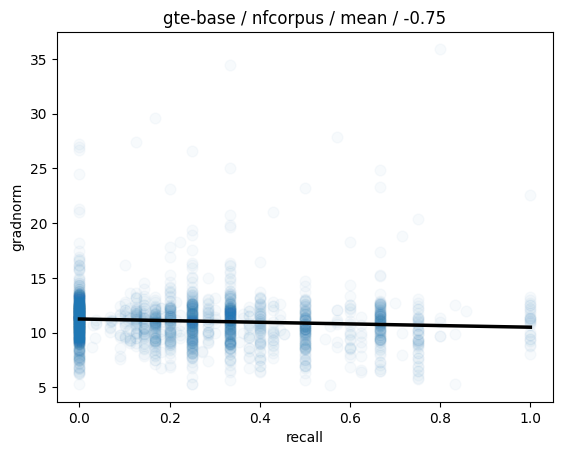

In [667]:
import matplotlib.pyplot as plt 

# Generate data
x = recalls
y = gradnorms

# Initialize layout
fig, ax = plt.subplots()

# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.03)

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
import numpy as np
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.xlabel("recall")
plt.ylabel("gradnorm")
#plt.ylim(15, 40)
plt.title(f"{model_name} / {dataset_name} / {selection} / {round(b, 2)}")
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

print(b)

-11.233075174785741


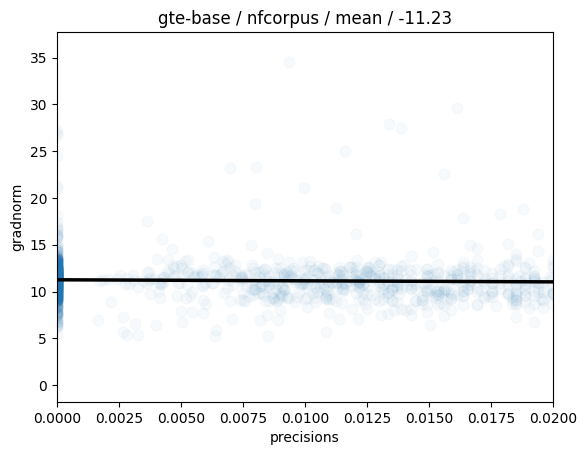

In [668]:
import matplotlib.pyplot as plt 

# Generate data
x = precisions
y = gradnorms

# Initialize layout
fig, ax = plt.subplots()

# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.03)

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
import numpy as np
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.xlabel("precisions")
plt.ylabel("gradnorm")
plt.xlim(0, 0.02)
plt.title(f"{model_name} / {dataset_name} / {selection} / {round(b, 2)}")
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

print(b)

-0.5129507858024782


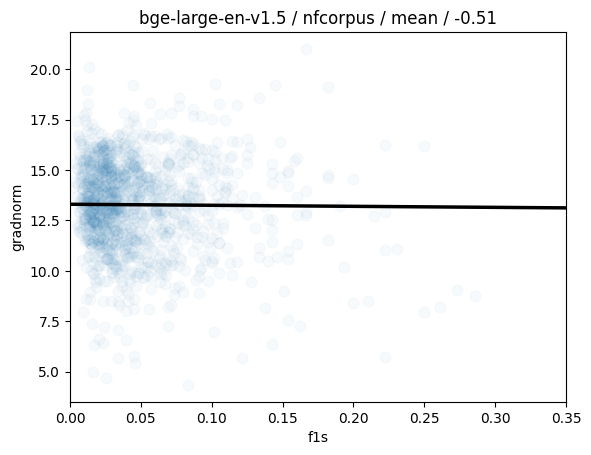

In [611]:
import matplotlib.pyplot as plt 

# Generate data
x = f1s
y = gradnorms

# Initialize layout
fig, ax = plt.subplots()

# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.03)

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
import numpy as np
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.xlabel("f1s")
plt.ylabel("gradnorm")
plt.xlim(0)
plt.title(f"{model_name} / {dataset_name} / {selection} / {round(b, 2)}")
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

print(b)

0.0490486937097026


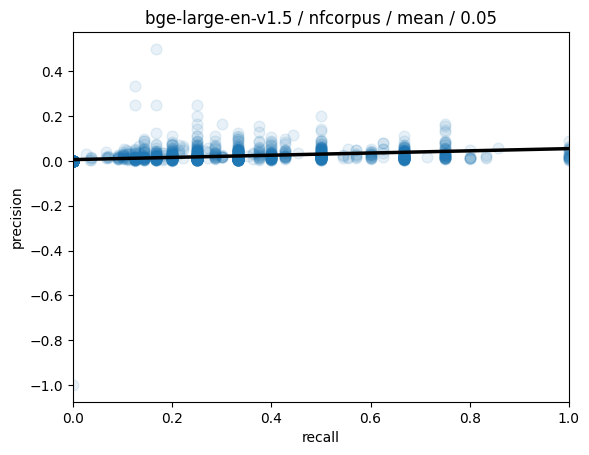

In [612]:
import matplotlib.pyplot as plt 

# Generate data
y = precisions
x = recalls 


# Initialize layout
fig, ax = plt.subplots()

# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.1)

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
import numpy as np
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.xlabel("recall")
plt.ylabel("precision")
plt.xlim(0, 1)
plt.title(f"{model_name} / {dataset_name} / {selection} / {round(b, 2)}")
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

print(b)

### Load grad norm and plot mean 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


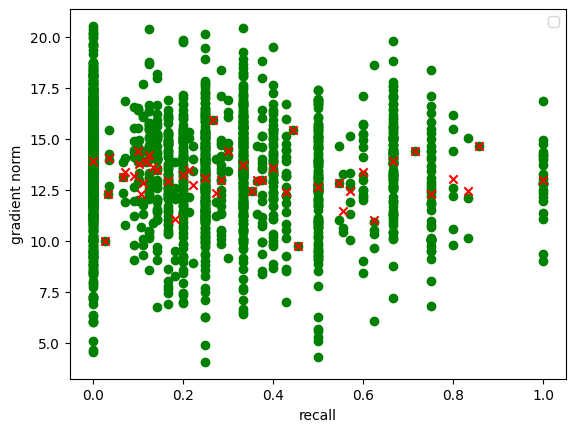

In [483]:

import matplotlib.pyplot as plt 
plt.figure()
plt.scatter(recalls, gradnorms, color="green")
plt.xlabel("recall")
plt.ylabel("gradient norm")
#plt.plot(ood_well_o, len(ood_well_o) * [0], "o" , label = "ood-well(tp_over_t>0.4)", color="blue")
#plt.plot(ood_poor, len(ood_poor) * [1], "x" , label = "ood-poor", color="red")

means = {k: [] for k in set(recalls)}
for r, g in zip(recalls, gradnorms):
    means[r].append(g)
means = {k: sum(v) / len(v) for k, v in means.items()}
means = sorted(list(means.items()), key= lambda x: int(x[0]))
xs = [i[0] for i in means]
ys = [i[1] for i in means]
plt.scatter(xs, ys, marker="x", color="red")
plt.legend()
 